In [2]:
import sys
print sys.path

import psycopg2 as ppg

con = ppg.connect("dbname=tweets user=patrick")
print con

['', '/home/patrick/anaconda/lib/python27.zip', '/home/patrick/anaconda/lib/python2.7', '/home/patrick/anaconda/lib/python2.7/plat-linux2', '/home/patrick/anaconda/lib/python2.7/lib-tk', '/home/patrick/anaconda/lib/python2.7/lib-old', '/home/patrick/anaconda/lib/python2.7/lib-dynload', '/home/patrick/anaconda/lib/python2.7/site-packages', '/home/patrick/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-linux-x86_64.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/setuptools-17.0-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/IPython/extensions']
<connection object at 0x7fca690155c8; dsn: 'dbname=tweets user=patrick', closed: 0>


In [3]:
#cur = con.cursor()
#cur.execute("SELECT tweet_id FROM tweets;")
#tweet_id = set(zip(*cur.fetchall())[0])
#cur.close()

Populating the interactive namespace from numpy and matplotlib
freq    365215
dtype: int64


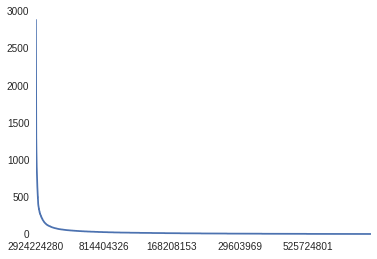

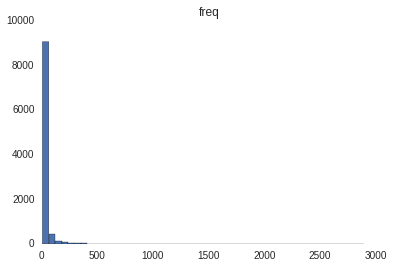

In [67]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

with con.cursor() as cur:
    cur.execute("SELECT user_id FROM tweets;")
    users = zip(*cur.fetchall())[0]

user_counts = pd.DataFrame({ 'freq': pd.Series(users).value_counts() })
user_counts[user_counts.freq>10].freq.plot()
user_counts[user_counts.freq>10].hist(bins=50)
print user_counts[user_counts.freq>10].sum()

In [5]:
# with con.cursor() as cur:
#     cur.execute("SELECT tweet_id, user_id, in_reply_to_tweet_id FROM tweets")
#     tweets_list = cur.fetchall()
# tweets = pd.DataFrame(tweets_list, columns=['tweet_id','user_id','reply_id']).set_index('tweet_id')
# %timeit replied_to = tweets[tweets.reply_id != 'None'].reply_id.values
# tweet_ids = set(tweets.index)
# %timeit questions = tweets[[twid in replied_to for twid in tweet_ids]]
# print questions

In [6]:
# replies = tweets[tweets.reply_id != 'None']
# hanging_questions= pd.Series([rid for rid in replies.reply_id if rid not in questions.tweet_id.values])
# print hanging_questions

Base rate of @-mentions
Base rate of in-reply-to's
Find variation across users in in-reply-to's/total num. tweets
Ratio by user of outgoing @mention rate to in-reply-to (to all that user's tweets)

In [58]:
# # annotate tweets with initial @mention rate
# at_ment_re = re.compile(r"^\s+\.?@")
# tweets['at_mention'] = tweets.text.apply(lambda x:
#      at_ment_re.search(x) is not None)
                                         

# users_grps = tweets.groupby('user_id')
# users_df = users_grps.apply(lambda x: pd.DataFrame({'num_at_out': x.at_mention.sum(),
#                                                     'num_at_in': 
#reload(seaborn)
con.rollback()

Index([u'tweet_id', u'user_id', u'tweet_lat', u'tweet_long', u'followers_count', u'friends_count', u'user_location', u'user_lat', u'user_long', u'in_us', u'num_tweets_user', u'tweet_distance', u'on_road', u'any_on_road', u'num_on_road'], dtype='object')


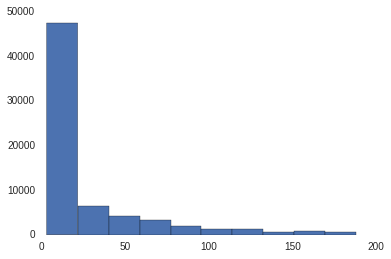

In [78]:
# Explore geotags
usa = (-125.6791025,25.4180700649,-66.885417,
                           49.3284551525)    
with con.cursor() as cur:
    cur.execute("SELECT tw.tweet_id, tw.user_id, tw.lat as tweet_lat, tw.long as tweet_long, "
                "user_locs.followers_count,user_locs.friends_count, "
                "user_locs.place as user_location, plcs.user_lat, "
                "plcs.user_long "
                "FROM tweets as tw, (SELECT user_id, place, friends_count, followers_count "
                "FROM users) as user_locs, "
                "(SELECT place, coded_lat as user_lat, coded_long as user_long FROM "
                "places) as plcs "
                "WHERE tw.user_id = user_locs.user_id and user_locs.place != 'None' "
                "and plcs.place = user_locs.place AND plcs.user_lat != -500 AND "
                "plcs.user_long != 500 AND (user_locs.place ~* '[A-Z\s]+,\s*[A-Z]+' OR "
                "user_locs.place ~* '(New York City|NYC|LA|Los Angeles|Chicago|DC|SF|San Francisco|"
                "Detroit|Houston|Dallas|Atlanta|Philly|Philadelphia|Phoenix|San Antonio| "
                "San Jose|Austin|Jacksonville|Indianapolis|Denver)');")
    
    geotags = pd.DataFrame(cur.fetchall(), 
                       columns=[c[0] for c in cur.description])
    
in_us = pd.Series((geotags['tweet_long'] > usa[0]) & (geotags['tweet_long'] < usa[2]) &
                    (geotags['tweet_lat'] > usa[1]) & (geotags['tweet_lat'] < usa[3]))

geotags['in_us'] = in_us

geotags= geotags.merge(geotags.groupby('user_id').apply(lambda x: pd.Series(x.shape[0], index=['num_tweets_user'])),
                    left_on='user_id', right_index=True, how='left')

# drop certain users
geotags = geotags[(geotags.followers_count < 2000) & 
                  (geotags.friends_count < 1800) &
                  (geotags.num_tweets_user < 200) &
                  (geotags.num_tweets_user >= 3)]

# look at distance between user location and tweet location

geotags['tweet_distance'] = np.sqrt((geotags.user_lat - geotags.tweet_lat) ** 2 + 
                                    (geotags.user_long - geotags.tweet_long) ** 2)
geotags['on_road'] = geotags['tweet_distance'] > 0.5

# get number of users w/ any on-road tweets, other per-user stats
users_on_road=geotags.groupby('user_id').apply(lambda x: pd.Series([x.on_road.any(), x.on_road.sum()],
         index=['any_on_road','num_on_road']))
geotags = geotags.merge(users_on_road, left_on='user_id', right_index=True)

geotags.num_tweets_user.hist()
print geotags.columns


In [68]:
print "Number NA user lat/long: " + str(geotags[['user_id', 'user_lat']].drop_duplicates().user_lat.isnull().sum())
print geotags.shape
geotags.head(10)

Number NA user lat/long: 0
(100, 10)


,tweet_id,user_id,tweet_lat,tweet_long,followers_count,friends_count,user_location,user_lat,user_long,in_us
0,606500527669690368,26627601,33.439725,-86.861576,110,109,"Birmingham, AL",33.520658,-86.802486,True
1,606500564797681665,9800212,40.694886,-74.173731,198,119,"Brooklyn, NY",40.650100,-73.949579,True
2,606500575648358400,30328214,34.087900,-118.372000,915,1666,"Los Angeles, CA",34.052227,-118.243680,True
3,606500587392221184,3151846291,29.929751,-95.493272,72,163,"Texas, USA",31.968599,-99.901813,True
4,606500588122021888,388009236,25.881445,-80.291862,386,251,"Jacksonville, FL",30.332178,-81.655649,True
5,606500590928150528,14132503,39.094401,-77.153004,9549,7731,Washington DC,38.895107,-77.036368,True
6,606500600642170880,57159482,28.266385,-82.669776,393,1160,"Tampa, Florida",27.950575,-82.457178,True
7,606500618132430848,182738206,33.692310,-117.881033,364,34,Cleveland,41.499320,-81.694361,True
8,606500625153560576,120647974,26.157174,-80.286226,414,287,"Ft. Lauderdale, FL",26.122439,-80.137317,True
9,606500627624165376,182738206,37.802928,-122.414212,364,34,Cleveland,41.499320,-81.694361,True


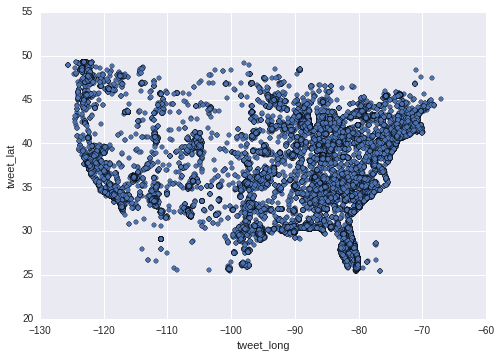

In [10]:
geotags[geotags['in_us']==True].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#LA

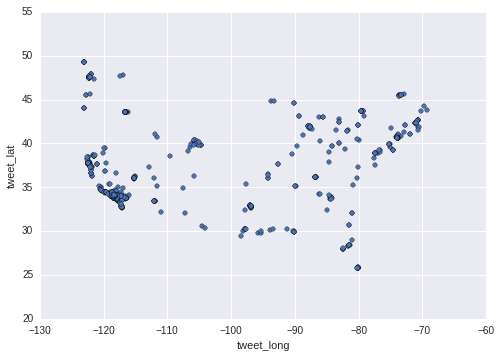

In [11]:
geotags[geotags['user_location']=="Los Angeles, CA"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#NYC

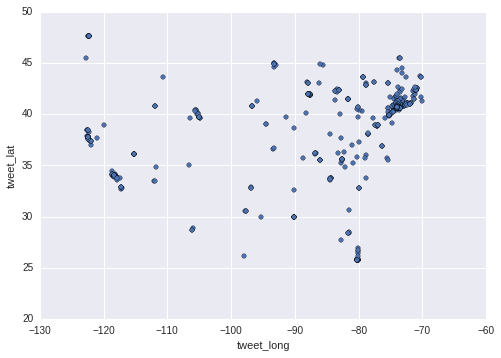

In [12]:
geotags[geotags['user_location']=="New York, NY"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

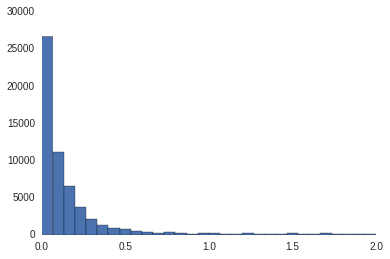

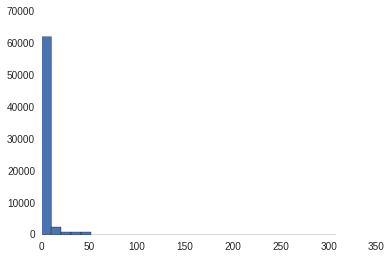

In [81]:
#print geotags.ix[np.argmax(geotags['tweet_distance'])]
#((geotags.user_lat - geotags.tweet_lat) ** 2).describe()
plt.figure(1)
geotags.tweet_distance.hist(bins=30)
plt.figure(2)
geotags[geotags.tweet_distance < 2].tweet_distance.hist(bins=30)


In [18]:
#explore follower count etc. (in original data)
with con.cursor() as cur:
    cur.execute("SELECT user_id, friends_count, followers_count FROM users")
    ffdf = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])
    

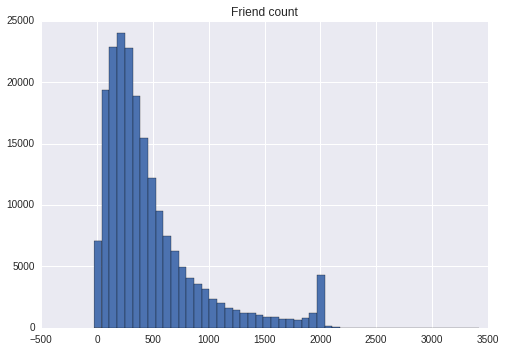

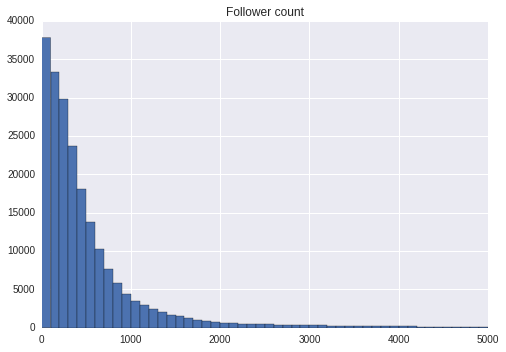

In [52]:
plt.figure(1)
ffdf[(ffdf.friends_count < 5000) & (ffdf.followers_count < 2000)].friends_count.hist(bins=50)
#plt.xlim([0,5000])
plt.title("Friend count")
plt.figure(2)
ffdf[ffdf.followers_count < 5000].followers_count.hist(bins=50)
plt.xlim([0,5000])
plt.title("Follower count")

                 tweet_id    user_id  tweet_lat  tweet_long  followers_count  \
71983  606528369459609602  348180503  41.653215  -83.625126              403   
75754  606567048253161473  348180503  41.652978  -83.626449              403   
80807  608427481620750337  348180503  41.654575  -83.621817              403   

       friends_count user_location   user_lat  user_long in_us  \
71983            395    Detroit MI  42.331427 -83.045754  True   
75754            395    Detroit MI  42.331427 -83.045754  True   
80807            395    Detroit MI  42.331427 -83.045754  True   

       num_tweets_user  tweet_distance on_road any_on_road  num_on_road  
71983                3        0.891989    True        True            3  
75754                3        0.893029    True        True            3  
80807                3        0.888807    True        True            3  


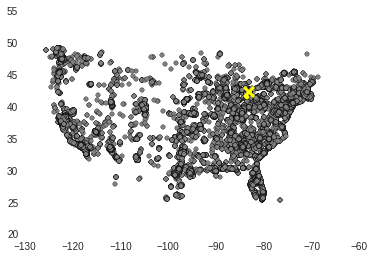

In [83]:
import random
plt.scatter(geotags[geotags['in_us']==True]['tweet_long'],geotags[geotags['in_us']==True]['tweet_lat'],
           c='gray')
# random user's home location
random_user = geotags.loc[random.sample(geotags[geotags.on_road].index, 1), 'user_id']


user_tweets = geotags[geotags['user_id']==random_user.values[0]]
print user_tweets
plt.scatter(user_tweets.tweet_long, user_tweets.tweet_lat,
            c='yellow', marker='.', s=100)
plt.scatter(user_tweets.user_long.drop_duplicates(), user_tweets.user_lat.drop_duplicates(), 
            c='yellow', marker='x', linewidth = '3', s=100)


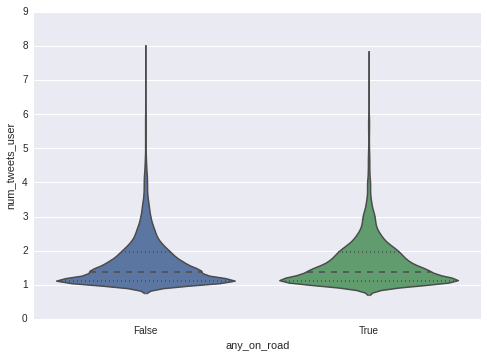

In [15]:
# compare number of tweets between on/off road
tweet_freqs = geotags[(geotags['num_tweets_user'] >= 3)][['user_id','num_tweets_user','any_on_road']]. \
    drop_duplicates()
#plt.axis([None, None, 0,5])

seaborn.violinplot(tweet_freqs.num_tweets_user.map(np.log), groupby=tweet_freqs.any_on_road)

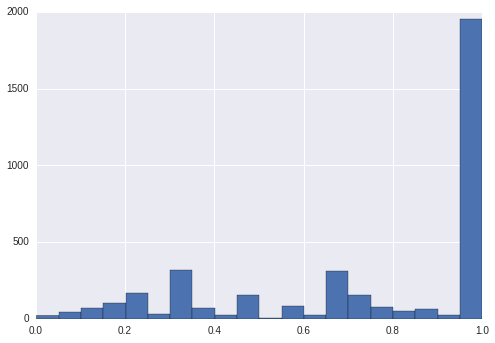

In [16]:
# for users who have 3+ tweets and any on road, 0-1 distribution of proportion of tweets on road?
geotags[(geotags['num_tweets_user'] >= 3) & (geotags.any_on_road > 0)]. \
    groupby('user_id').apply(
    lambda x: float(x.num_on_road.sum()) / float(x.num_tweets_user.sum())).hist(bins=20)

In [17]:
# do logistic regression on topic features
num_topics = 10
first_topic = "topic_0"
last_topic = "topic_{}".format(num_topics - 1)
with con.cursor() as cur:
    cur.execute("SELECT user_id, " +
               ', '.join(["topic_{}".format(x) for x in range(0,num_topics)]) +
               " FROM users WHERE topic_0 is not NULL")
    topic_matrix = pd.DataFrame(cur.fetchall(), columns = ["user_id"] + 
                           ["topic_{}".format(x) for x in range(0,num_topics)])
geotopics = topic_matrix.merge(geotags[['user_id','any_on_road']].drop_duplicates(), on='user_id', how='left') 



In [18]:
print geotopics.dropna().any_on_road.shape[0]
print geotopics.dropna().any_on_road.sum()

response = geotopics.dropna()['any_on_road']
predictors = geotopics.dropna().loc[:,first_topic:last_topic]

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as skpre
import sklearn.cross_validation as skcv

random.seed(888)
train, test = skcv.train_test_split(pd.concat([pd.DataFrame(response), predictors], axis = 1))
train = pd.DataFrame(train, columns = ["any_on_road"] + predictors.columns.tolist())
test = pd.DataFrame(test, columns = ["any_on_road"] + predictors.columns.tolist())

scaler = skpre.StandardScaler()
scaler.fit(train.loc[:,first_topic:last_topic])
train_scaled = scaler.transform(train.loc[:,first_topic:last_topic])
test_scaled = scaler.transform(test.loc[:,first_topic:last_topic])
#predictors_scaled = skpre.scale(predictors)
#test

In [ ]:
logmodel = LogisticRegression()
model_results = logmodel.fit(train_scaled,train.any_on_road)


In [ ]:
predictions = model_results.predict(test_scaled)

In [ ]:
print float((test.any_on_road == False).sum())/float(test.shape[0])

In [ ]:
print float((predictions == test.any_on_road).sum())/float(test.shape[0])

In [ ]:
print (predictions == True).sum()

In [ ]:
# try SVM
from sklearn import svm
svmachine = svm.SVC(class_weight='auto')
model_results = svmachine.fit(train_scaled,train.any_on_road)

In [ ]:
predictions = model_results.predict(test_scaled)

In [ ]:
print float((test.any_on_road == False).sum())/float(test.shape[0])

In [ ]:
print float((predictions == test.any_on_road).sum())/float(test.shape[0])